In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# from helpers import *
# from gradient_descent import *
%load_ext autoreload
%autoreload 2

# Helper functions

In [2]:
def load_data():
    """load data."""
    data = np.loadtxt("dataEx3.csv", delimiter=",", skiprows=1, unpack=True)
    x = data[0]
    y = data[1]
    return x, y


def load_data_from_ex02(sub_sample=True, add_outlier=False):
    """Load data and convert it to the metric system."""
    path_dataset = "height_weight_genders.csv"
    data = np.genfromtxt(
        path_dataset, delimiter=",", skip_header=1, usecols=[1, 2])
    height = data[:, 0]
    weight = data[:, 1]
    gender = np.genfromtxt(
        path_dataset, delimiter=",", skip_header=1, usecols=[0],
        converters={0: lambda x: 0 if b"Male" in x else 1})
    # Convert to metric system
    height *= 0.025
    weight *= 0.454

    # sub-sample
    if sub_sample:
        height = height[::50]
        weight = weight[::50]

    if add_outlier:
        # outlier experiment
        height = np.concatenate([height, [1.1, 1.2]])
        weight = np.concatenate([weight, [51.5/0.454, 55.3/0.454]])

    return height, weight, gender


def standardize(x):
    """Standardize the original data set."""
    mean_x = np.mean(x)
    x = x - mean_x
    std_x = np.std(x)
    x = x / std_x
    return x, mean_x, std_x


def build_model_data(height, weight):
    """Form (y,tX) to get regression data in matrix form."""
    y = weight
    x = height
    num_samples = len(y)
    tx = np.c_[np.ones(num_samples), x]
    return y, tx

In [4]:
def calculate_mse(e):
    """Calculate the mse for vector e."""
    return 1/2*np.mean(e**2)


def compute_gradient(y, tx, w):
    """Compute the gradient."""
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err


def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute loss, gradient
        grad, err = compute_gradient(y, tx, w)
        loss = calculate_mse(err)
        # gradient w by descent update
        w = w - gamma * grad
        # store w and loss
        ws.append(w)
        losses.append(loss)
        #print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
        #      bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return ws, losses

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [5]:
def compute_mse(e):
    """Calculate the mse for vector e."""
    return 1/2*np.mean(e**2)

def compute_loss(y, tx, w):
    """Calculate the mse loss."""
    e = y - tx.dot(w)
    return compute_mse(e)

def least_squares(y, tx):
    """Calculate the least squares solution.
       returns mse, and optimal weights.
    """
    a = tx.T.dot(tx)
    b = tx.T.dot(y)
    w = np.linalg.solve(a, b)
    mse = compute_loss(y, tx, w)
    return w, mse

def least_squares_BAD_IMPLEMENTATION(y, tx):
    """This implementation of least_squares
    will result in numerical inaccuracies
    due to the matrix inverse operation
    """
    w = np.linalg.inv(tx.T @ tx) @ tx.T @ y
    mse = compute_loss(y, tx, w)
    return w, mse

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [6]:
def test_your_least_squares():
    # load data
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    # data preprocessing
    x, mean_x, std_x = standardize(height)
    # modeling
    y, tx = build_model_data(x, weight)
    w, mse = least_squares(y, tx)
    w_gd, mse_gd = gradient_descent(y, tx, initial_w=np.array([0,0]), max_iters=10, gamma=0.7)
    print("Solution LS: ", w, "MSE: ", mse)
    print("Solution GD: ", w_gd[-1], "MSE: ", mse_gd[-1])

Test it here

In [7]:
test_your_least_squares()

Solution LS:  [73.293922   13.47971243] MSE:  15.3858878688294
Solution GD:  [73.29348921 13.47963284] MSE:  15.385888944638305


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [8]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [16]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly = np.ones((len(x), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(x, deg)]
    return poly

# build_poly(np.arange(1,5),4)

In [17]:
# functions for plotting
def plot_fitted_curve(y, x, weights, degree, ax):
    """plot the fitted curve."""
    ax.scatter(x, y, color='b', s=12, facecolors='none', edgecolors='r')
    xvals = np.arange(min(x) - 0.1, max(x) + 0.1, 0.1)
    tx = build_poly(xvals, degree)
    f = tx.dot(weights)
    ax.plot(xvals, f)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Polynomial degree " + str(degree))

def plot_train_test(train_errors, test_errors, lambdas, degree):
    """
    train_errors, test_errors and lambas should be list (of the same size) the respective train error and test error for a given lambda,
    * lambda[0] = 1
    * train_errors[0] = RMSE of a ridge regression on the train set
    * test_errors[0] = RMSE of the parameter found by ridge regression applied on the test set
    
    degree is just used for the title of the plot.
    """
    plt.semilogx(lambdas, train_errors, color='b', marker='*', label="Train error")
    plt.semilogx(lambdas, test_errors, color='r', marker='*', label="Test error")
    plt.xlabel("lambda")
    plt.ylabel("RMSE")
    plt.title("Ridge regression for polynomial degree " + str(degree))
    leg = plt.legend(loc=1, shadow=True)
    leg.draw_frame(False)
    plt.savefig("ridge_regression")

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [18]:
def polynomial_regression(x:np.ndarray,degrees:list = [1, 3, 7, 12]):
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""   
    
    # define the structure of the figure
    num_row = 2
    num_col = int(len(degrees)/num_row) if (len(degrees)%num_row == 0) else 1 + (len(degrees)//num_row)
    f, axs = plt.subplots(num_row, num_col)
    axs = axs.ravel()
    for ind, degree in enumerate(degrees):
        # form dataset to do polynomial regression.
        tx = build_poly(x, degree)

        # least squares
        weights, mse = least_squares(y, tx)

        # compute RMSE
        rmse = np.sqrt(2 * mse)
        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.258582776677375
Processing 3th experiment, degree=5, rmse=0.25454339505731305
Processing 4th experiment, degree=7, rmse=0.24965870360907347
Processing 5th experiment, degree=12, rmse=0.24337224835783253
Processing 6th experiment, degree=50, rmse=0.23712135902694248


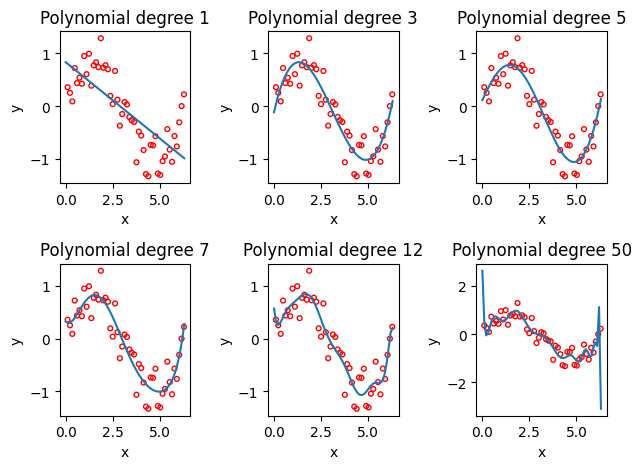

In [20]:
polynomial_regression(x=x,degrees=[1, 3, 5, 7, 12,50])

# 2 Evaluating model predication performance

Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [21]:
def split_data(x, y, ratio, seed=1):
    """split the dataset based on the split ratio."""
    # set seed
    np.random.seed(seed)
    # generate random indices
    num_row = len(y)
    indices = np.random.permutation(num_row)
    index_split = int(np.floor(ratio * num_row))
    index_tr = indices[: index_split]
    index_te = indices[index_split:]
    # create split
    x_tr = x[index_tr]
    x_te = x[index_te]
    y_tr = y[index_tr]
    y_te = y[index_te]
    return x_tr, x_te, y_tr, y_te

Then, test your `split_data` function below.

In [22]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    x_tr, x_te, y_tr, y_te = split_data(x, y, ratio, seed)
    # form tx
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)

    w, mse_tr = least_squares(y_tr, tx_tr)

    # calculate RMSE for train and test data.
    rmse_tr = np.sqrt(2 * mse_tr)
    rmse_te = np.sqrt(2 * compute_loss(y_te, tx_te, w))
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te)) 
    return y_tr, x_tr, y_te, x_te, w  

Demo time

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.181
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.206
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.220
proportion=0.9, degree=12, Training RMSE=0.242, Testing RMSE=0.254
proportion=0.7, degree=1, Training RMSE=0.516, Testing RMSE=0.352
proportion=0.7, degree=3, Training RMSE=0.249, Testing RMSE=0.308
proportion=0.7, degree=7, Training RMSE=0.227, Testing RMSE=0.333
proportion=0.7, degree=12, Training RMSE=0.223, Testing RMSE=0.327
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.531
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.296
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.284
proportion=0.5, degree=12, Training RMSE=0.205, Testing RMSE=1.531
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.534
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.460
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=1.990
proport

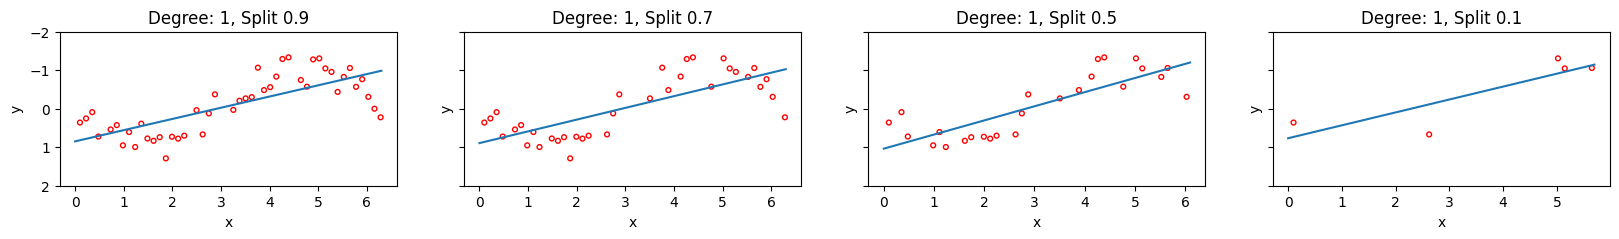

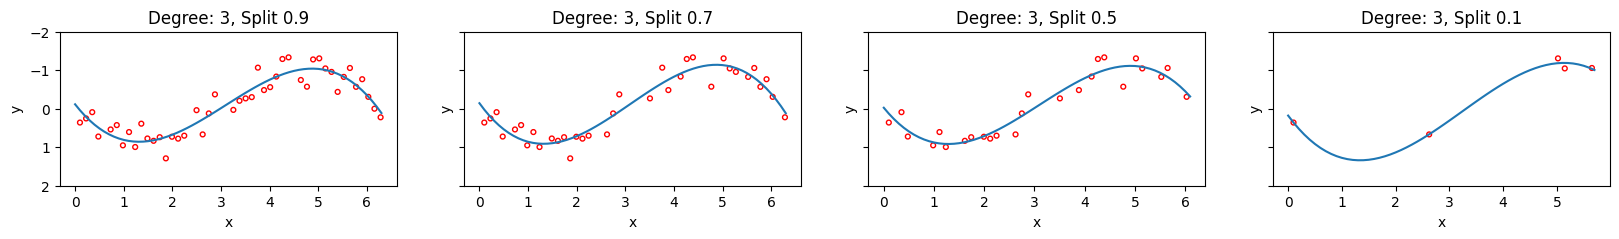

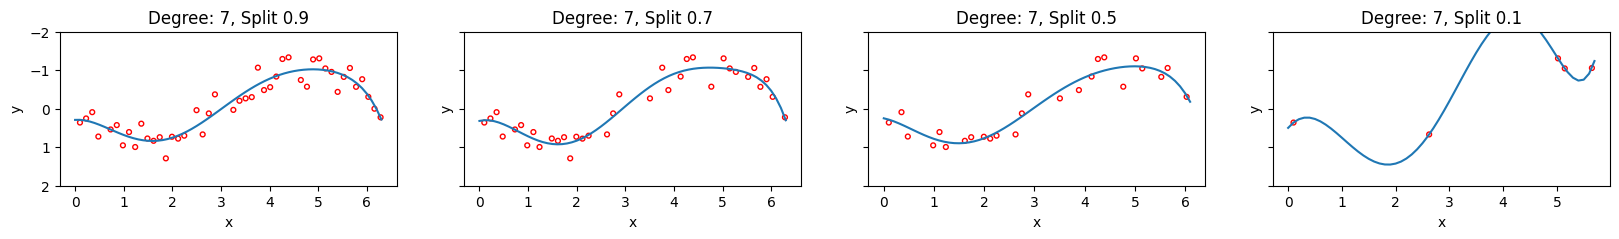

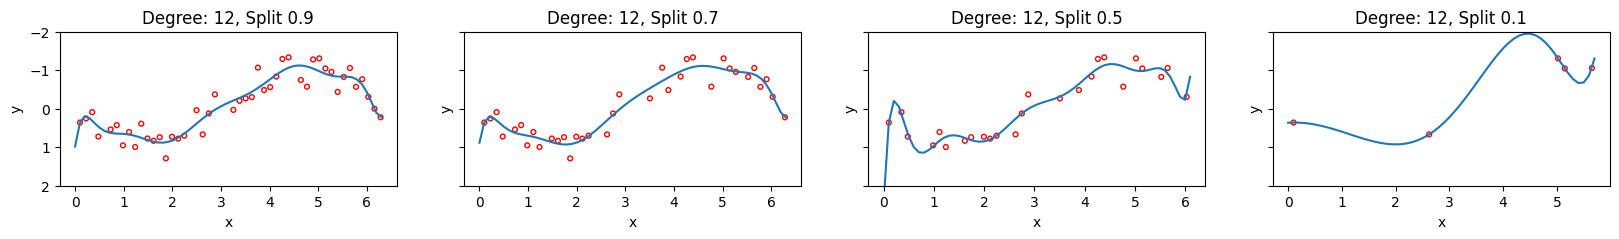

In [28]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.7, 0.5, 0.1]

# define the structure of the figure
num_row = 1
num_col = 4
axs = [plt.subplots(num_row, num_col, figsize=(20,2),sharey=True)[1] for _ in range(len(degrees))]

for ind, split_ratio in enumerate(split_ratios):
    for ind_d, degree in enumerate(degrees):
        y_tr, x_tr, y_te, x_te, w = train_test_split_demo(x, y, degree, split_ratio, seed)
        plot_fitted_curve(
            y_tr, x_tr, w, degree, axs[ind_d][ind % num_col])
        axs[ind_d][ind % num_col].set_title(f'Degree: {degree}, Split {split_ratio}')
        axs[ind_d][ind % num_col].set_ylim(2,-2)

# Ridge Regression - Hyperparameter tuning

In [29]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    aI = 2 * tx.shape[0] * lambda_ * np.identity(tx.shape[1])
    a = tx.T.dot(tx) + aI
    b = tx.T.dot(y)
    return np.linalg.solve(a, b)

In [30]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    # split data
    x_tr, x_te, y_tr, y_te = split_data(x, y, ratio, seed)
    # form tx
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)

    # ridge regression with different lambda
    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ridge regression
        weight = ridge_regression(y_tr, tx_tr, lambda_)
        rmse_tr.append(np.sqrt(2 * compute_loss(y_tr, tx_tr, weight)))
        rmse_te.append(np.sqrt(2 * compute_loss(y_te, tx_te, weight)))

        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

Demo time

proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.335
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.228, Testing RMSE=0.334
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.228, Testing RMSE=0.333
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.229, Testing RMSE=0.329
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.230, Testing RMSE=0.319
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.232, Testing RMSE=0.302
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.237, Testing RMSE=0.283
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.246, Testing RMSE=0.276
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.264, Testing RMSE=0.298
proportion=0.5, degree=7, lambda=0.193, 

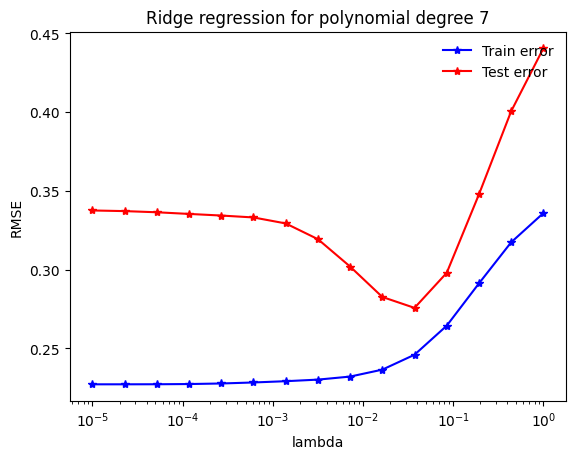

In [31]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)